### 추천 시스템 제작(하루3끼)

In [1]:
# %autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os

import numpy as np
import pandas as pd
import seaborn as sb

from IPython.display import Image

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam    # 가중치, bias 최적화

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt

from matplotlib import font_manager, rc

import platform 

if (platform.system() == 'Windows'):  # Windows, Linux, Darwin
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    plt.rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/ai7/dnn/recommendation' # Colab

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

In [2]:
# header가 있을경우 skiprows=1 선언
data = np.loadtxt(path + '/train1.csv', delimiter=',', skiprows=1, dtype=np.float64)   # 특성이 작은 데이터의 예외 추가
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(21771, 26)


In [3]:
# 데이터와 class의 분리
# 0: 닭가슴살
# 1: 간편요리
# 2: 샐러드
# 3: 건강미용
# 4: 간식
X = data[:, 0:25]  # 0 ~ 24
print(X.shape)
Y = data[:, 25]    # 25 번째 데이터, class의 분리
print(Y.shape)

(21771, 25)
(21771,)


In [4]:
print(Y)

[0. 1. 2. ... 4. 4. 4.]


In [5]:
Y = Y.astype('int') # 정수로 형변환
print(Y)

[0 1 2 ... 4 4 4]


In [6]:
# 0: 닭가슴살
# 1: 간편요리
# 2: 샐러드
# 3: 건강미용
# 4: 간식
Y_encoded = to_categorical(Y) # one-hot-encoding

print(Y_encoded) 

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [7]:
print(X[0])
print(Y_encoded[0])

[0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01
 0.01 0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01 0.01]
[1. 0. 0. 0. 0.]


In [8]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
seed = 0
# 90%: 분할대기, 10%: 테스트
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y_encoded,
                                           stratify=Y_encoded,
                                           test_size=0.1,
                                           random_state=seed)
# 나머지 데이터 90%를 분할, 80%: 훈련, 20%: 검증
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                           stratify=y_train_all,
                                           test_size=0.2,
                                           random_state=seed)

print(y_val)
print(y_val.shape)
# 닭가슴살: 0 , 간편요리: 1, 샐러드: 2 , 건강미용 : 3 , 간식 : 4
# (67, 5): 67건의 데이터가 입력되어 한건당 5가지에 속할 확률이 출력됨으로 67행 5열이됨.

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
(3919, 5)


In [9]:
print(y_test)
print(y_test.shape)
# (37, 5): 37건의 데이터가 입력되어 한건당 5가지에 속할 확률이 출력됨으로 37행 5열이됨.

[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
(2178, 5)


In [22]:
model = Sequential()

# 네트워크 구성
# model.add(Dense(20, input_shape=(25, ), activation='relu'))
model.add(Dense(5, input_dim=25, activation='relu'))
# 0.98 0.01 0.01 0.98 0.01 0.01 0.98 0.01 0.01 -> 1 0 0 → 0 ~ 1 사이의 확률 5가지 출력, 총합은 1
model.add(Dense(5, activation='softmax'))
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', 
                                metrics=['accuracy'])
model.summary()

mcp = ModelCheckpoint(filepath='./3kki6.h5', monitor='val_accuracy',
                      verbose=1, save_best_only=True)

es = EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)

hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=False,
                 epochs=100, batch_size=5, callbacks=[mcp, es])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 5)                 130       
                                                                 
 dense_5 (Dense)             (None, 5)                 30        
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3123/3135 [============================>.] - ETA: 0s - loss: 1.0104 - accuracy: 0.6052
Epoch 1: val_accuracy improved from -inf to 0.71651, saving model to .\3kki6.h5
3135/3135 [==============================] - 10s 3ms/step - loss: 1.0091 - accuracy: 0.6054 - val_loss: 0.7064 - val_accuracy: 0.7165
Epoch 2/100
3120/3135 [============================>.] - ETA: 0s - loss: 0.6291 - accuracy: 0.7286
Epoch 2: val_accuracy improved from 0.71

Epoch 27/100
3130/3135 [============================>.] - ETA: 0s - loss: 0.4772 - accuracy: 0.7547
Epoch 27: val_accuracy did not improve from 0.75504
3135/3135 [==============================] - 8s 3ms/step - loss: 0.4771 - accuracy: 0.7547 - val_loss: 0.4775 - val_accuracy: 0.7522
Epoch 28/100
3135/3135 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.7544
Epoch 28: val_accuracy did not improve from 0.75504
3135/3135 [==============================] - 7s 2ms/step - loss: 0.4770 - accuracy: 0.7544 - val_loss: 0.4774 - val_accuracy: 0.7522
Epoch 29/100
3126/3135 [============================>.] - ETA: 0s - loss: 0.4770 - accuracy: 0.7548
Epoch 29: val_accuracy did not improve from 0.75504
3135/3135 [==============================] - 7s 2ms/step - loss: 0.4768 - accuracy: 0.7548 - val_loss: 0.4773 - val_accuracy: 0.7517
Epoch 30/100
3119/3135 [============================>.] - ETA: 0s - loss: 0.4767 - accuracy: 0.7549
Epoch 30: val_accuracy did not improve from 0

Epoch 56/100
3129/3135 [============================>.] - ETA: 0s - loss: 0.4753 - accuracy: 0.7536
Epoch 56: val_accuracy did not improve from 0.75504
3135/3135 [==============================] - 14s 4ms/step - loss: 0.4752 - accuracy: 0.7535 - val_loss: 0.4758 - val_accuracy: 0.7525
Epoch 57/100
3131/3135 [============================>.] - ETA: 0s - loss: 0.4754 - accuracy: 0.7533
Epoch 57: val_accuracy did not improve from 0.75504
3135/3135 [==============================] - 14s 4ms/step - loss: 0.4751 - accuracy: 0.7534 - val_loss: 0.4757 - val_accuracy: 0.7525
Epoch 58/100
3130/3135 [============================>.] - ETA: 0s - loss: 0.4752 - accuracy: 0.7535
Epoch 58: val_accuracy did not improve from 0.75504
3135/3135 [==============================] - 11s 4ms/step - loss: 0.4751 - accuracy: 0.7535 - val_loss: 0.4757 - val_accuracy: 0.7522
Epoch 59/100
3135/3135 [==============================] - ETA: 0s - loss: 0.4751 - accuracy: 0.7535
Epoch 59: val_accuracy did not improve fro

Epoch 85/100
3128/3135 [============================>.] - ETA: 0s - loss: 0.4747 - accuracy: 0.7526
Epoch 85: val_accuracy did not improve from 0.75504
3135/3135 [==============================] - 7s 2ms/step - loss: 0.4746 - accuracy: 0.7526 - val_loss: 0.4751 - val_accuracy: 0.7535
Epoch 86/100
3114/3135 [============================>.] - ETA: 0s - loss: 0.4743 - accuracy: 0.7531
Epoch 86: val_accuracy did not improve from 0.75504
3135/3135 [==============================] - 6s 2ms/step - loss: 0.4745 - accuracy: 0.7526 - val_loss: 0.4751 - val_accuracy: 0.7535
Epoch 87/100
3127/3135 [============================>.] - ETA: 0s - loss: 0.4746 - accuracy: 0.7525
Epoch 87: val_accuracy did not improve from 0.75504
3135/3135 [==============================] - 7s 2ms/step - loss: 0.4745 - accuracy: 0.7525 - val_loss: 0.4751 - val_accuracy: 0.7535
Epoch 88/100
3132/3135 [============================>.] - ETA: 0s - loss: 0.4748 - accuracy: 0.7524
Epoch 88: val_accuracy did not improve from 0

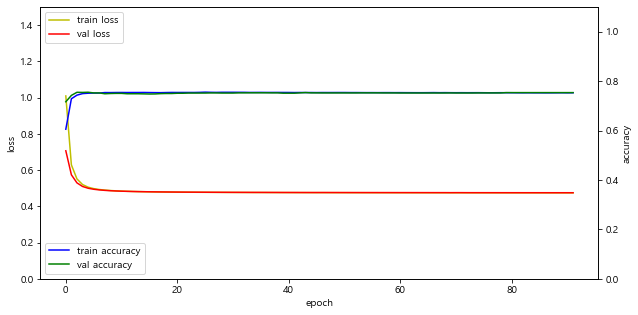

손실값: 0.4750111401081085 /정확도: 75.35085678100586 %


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.5]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.1])

# 축 레이블 설정
loss_ax.set_xlabel('epoch' )  # 학습 횟수
loss_ax.set_ylabel('loss')    # 왼쪽 y 축 레이블, 오차
acc_ax.set_ylabel('accuracy') # 오른쪽 y 축 레이블,정확도

loss_ax.legend(loc='upper left') # 왼쪽 y 축 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 오른쪽 y 축 정확도 레이블 위치

plt.show()

test_loss, test_acc = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

In [24]:
# model.save(path + '/Book.h5')

In [25]:
print('데이터:', x_test.shape) # 변수가 9개로 구성된 4건의 관측치(행)
print('데이터:', x_test[0])    # 첫번째 데이터행

p = model.predict(x_test)      # 테스트 데이터 4건 ★
print('예측 결과 p.shape:', p.shape)     # (4, 3): 3: 폼종의 갯수

데이터: (2178, 25)
데이터: [0.01 0.01 0.01 0.96 0.01 0.96 0.01 0.01 0.01 0.01 0.01 0.01 0.96 0.01
 0.01 0.96 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.96 0.01]
69/69 [==============================] - 0s 2ms/step
예측 결과 p.shape: (2178, 5)


In [26]:
print('예측값:', p[0])        # 첫번째 예측값 출력, 확률 0 ~ 1사이의 실수값
print('예측값의 합: {0:0.3f}'.format(np.sum(p[0])))
print('예측값: {0:.5f}% {1:.5f}% {2:.5f}%'.format(p[0,0]*100,p[0,1]*100,p[0,2]*100))
print('One-hot-encoding: ', y_test[0])
print(np.argmax(p[0]))      # 가장 큰값의 index

예측값: [6.3530654e-01 2.0167636e-06 1.7068901e-03 3.6298233e-01 2.2225649e-06]
예측값의 합: 1.000
예측값: 63.53065% 0.00020% 0.17069%
One-hot-encoding:  [1. 0. 0. 0. 0.]
0


In [27]:
print(p)

[[6.3530654e-01 2.0167636e-06 1.7068901e-03 3.6298233e-01 2.2225649e-06]
 [1.7017986e-04 1.2449580e-03 5.6994694e-01 4.2863405e-01 3.7900606e-06]
 [1.1538106e-03 2.9497873e-04 1.5026773e-03 9.9704748e-01 1.1226291e-06]
 ...
 [2.3019653e-07 1.2798951e-10 7.9607793e-07 1.7830736e-13 9.9999893e-01]
 [2.1715101e-03 8.5983239e-04 4.5294883e-06 9.9577504e-01 1.1891844e-03]
 [5.4160374e-01 4.5815694e-01 9.3220501e-07 2.3588669e-04 2.5417989e-06]]
